In [1]:
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import cv2
from tensorflow.python.keras.utils import Sequence
import pandas as pd
class RegionDataGenerator(Sequence):
    """
        Inherits the Keras Sequence to generate batch data from images.
        Blackbox works:
            1. Takes healthy corn images, infected corn images, annotation file directory.
            2. For each image index on batch, performs below:-
                (Done some image operations like flipping to make sure image is positioned right.)
                a. Read image(healthy and infected) for infected image, finds bounding boxes.
                b. Append each bounding box's infected image patch to list and take same bounding box's patch from healthy
                    and also do categorical labeling.([1, 0] for infected, [0, 1] for healthy.)
    """
    
    def __init__(self, ndir="Healthy corn/", idir="Infected/", 
                 adf="Annotation/vott-csv-export/Annotation-export.csv", 
                 target_size=(128,128), batch_size=16, bounding_boxes=20):
        
        """ 
           Blackbox works:
                1. Takes healthy corn images, infected corn images, annotation file directory.
                2. For each image index on batch, performs below:-
                    (Done some image operations like flipping to make sure image is positioned right.)
                    a. Read image(healthy and infected) for infected image, finds bounding boxes.
                    b. Append each bounding box's infected image patch to list and take same bounding box's patch from healthy
                        and also do categorical labeling.([1, 0] for infected, [0, 1] for healthy.)
                3. The batch size here is not real batch size but this batch size is used to get images of this size.
                4. Each image is assumed to have atleast 2 patches.
                5. Single batch contains more than: batch_size * 2 * 2 examples.
        """
    
        ndirs = ["Healthy corn/"+d for d in os.listdir(ndir)]
        idirs = ["Infected/"+d for d in os.listdir(idir)][:len(ndirs)]
        adf = pd.read_csv(adf)

        self.x = np.arange(len(ndirs))
        self.batch_size = batch_size
        self.adf = adf
        self.idirs = idirs
        self.ndirs = ndirs
        self.target_size = target_size
        print(f"Total {len(ndirs) * 2} examples.")
        
    def __len__(self):
        return int(np.ceil(len(self.x)/float(self.batch_size)))
    
    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx+1) * self.batch_size]
        #batch_y = self.y[idx * self.batch_size:(idx+1) * self.batch_size]
        
        x, y = self.generate_patches(batch_x)
        #print(batch.shape)
        return x, y
    
    def generate_patches(self, ids):
        
        """
            ids:- id or index of image names taken from directory.
            returns x, y from batch of indices but batch size will be greater than len(ids)
        """
        
        examples= []
        lbls = []
        for i in ids:
            fnimg = ndirs[i]
            iimg = idirs[i]
            annotation = adf[adf.image == iimg.split("/")[1]]
            #print(annotation)
            if len(annotation) > 0:
                img = cv2.imread(iimg)
                img = np.rot90(img)
                nimg = cv2.imread(fnimg)
                simg = img.shape
                nimg = cv2.resize(nimg, (simg[0], simg[1]))
                nimg = np.rot90(nimg)

                rect= []
                for _,row in annotation.iterrows():
                    r = [row.xmin, row.ymin, row.xmax, row.ymax]
                    r = np.array(r).astype("int")
                    try:
                        if r[1] < r[3] or r[0] < r[2]: 
                            ipatch = cv2.resize(img[r[1]:r[3], r[0]: r[2]], target_size)/255
                            npatch = cv2.resize(nimg[r[1]:r[3], r[0]: r[2]], target_size)/255
                            #yield (np.array([[x/n]]), np.array([2*x/n]))
                            examples.append(np.array(ipatch))
                            lbls.append(np.array([1, 0]))
                            examples.append(np.array(npatch))
                            lbls.append(np.array([0, 1]))
                            
                            #cv2.rectangle(img, (r[0], r[1]), (r[2], r[3]), (0, 0, 0), 25)
                            #show(img)
                            #plt.imshow(img[r[1]:r[3], r[0]: r[2]])
                            #plt.show()
                    except:
                        pass
        examples = np.array(examples)
        lbls = np.array(lbls)
        #print(examples.shape, lbls.shape)
        return examples, lbls
        #examples, lbls = [], []
#                 break

    
# generator = RegionDataGenerator(target_size=(128, 128), batch_size=8)
# for i in range(1):
#     generator.__getitem__(i)

In [11]:
class BBDataGenerator(Sequence):
    def __init__(self, ndir="Healthy corn/", idir="Infected/", 
                 adf="Annotation/vott-csv-export/Annotation-export.csv", 
                 target_size=(128,128), batch_size=16, max_boxes=20):
        
        """ 
           Blackbox works:
                1. Takes healthy corn images, infected corn images, annotation file directory.
                2. For each image index on batch, performs below:-
                    (Done some image operations like flipping to make sure image is positioned right.)
                    a. Read image(healthy and infected) for infected image, finds bounding boxes.
                    b. Append each bounding box's infected image patch to list and take same bounding box's patch from healthy
                        and also do categorical labeling.([1, 0] for infected, [0, 1] for healthy.)
                3. The batch size here is not real batch size but this batch size is used to get images of this size.
                4. Each image is assumed to have atleast 2 patches.
                5. Single batch contains more than: batch_size * 2 * 2 examples.
        """
    
        ndirs = ["Healthy corn/"+d for d in os.listdir(ndir)]
        idirs = ["Infected/"+d for d in os.listdir(idir)][:len(ndirs)]
        self.df = pd.read_csv(adf)

        self.x = np.arange(len(ndirs))
        self.batch_size = batch_size
        self.adf = adf
        self.idirs = idirs
        self.ndirs = ndirs
        self.target_size = target_size
        self.num_boxes = max_boxes
        
        print(f"Total {len(ndirs)} examples. {int(len(ndirs)/batch_size)} examples per batch.")
        
    def __len__(self):
        return int(np.ceil(len(self.x)/float(self.batch_size)))
    
    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx+1) * self.batch_size]
        #batch_y = self.y[idx * self.batch_size:(idx+1) * self.batch_size]
        
        x, y = self.generate_bb(batch_x)
        #print(batch.shape)
        return x, y
    def generate_bb(self, ids):
        
        """
            ids:- id or index of image names taken from directory.
            returns x, y from batch of indices but batch size will be greater than len(ids)
        """
        
        examples= []
        lbls = []
        for i in ids:
            #print(i)
            boxes = np.zeros((self.num_boxes, 4))
            iimg = self.idirs[i]
            annotation = self.df[self.df.image == iimg.split("/")[1]]
            #print(annotation)
            if len(annotation) > 0:
                img = cv2.imread(iimg)
                img = np.rot90(img)
                rect= []
                shape = img.shape
                
                #print(shape)
                img = cv2.resize(img, self.target_size)
                examples.append(img/255)
                
                # because img is flipped 90 degree, row col changes and fraction to multiply also
                dr = self.target_size[1]/shape[1]
                dc = self.target_size[0]/shape[0]
                
                #print(dr, dc)
                rect_toshow = []
                for _, row in annotation.iterrows():
                    #rect.append([row.xmin, row.ymin, row.xmax, row.ymax])
                    r = [row.xmin, row.ymin, row.xmax, row.ymax]
                    r = np.array(r)
                    r[[0, 2]] = r[[0, 2]] * dr
                    r[[1, 3]] = r[[1, 3]] * dc
                    r = r.astype(np.int)

                    
                    rect_toshow.append(r)
                
                boxes[:len(rect_toshow)] = rect_toshow
                lbls.append(boxes)
        lbls = np.array(lbls).reshape(-1, self.num_boxes * 4)/self.target_size[0]
        examples = np.array(examples)
        return examples, lbls
    
        
    def prepare_data(self):
        """
            loop through the data_dir 
                open an image
                pass it to Regionproposal's forward and get its yield value which will be(
                    indices of part of image or current region's extreme positions i.e cexp
                    read the label file and get the values for current image and check its xmin xmax.. values
                    if current cexp is in range of any of xmin xmax values then there is infected part on that position
                    so make this portion's label 1 else make label 0. [what if cexp is only on some part of xmin xmax..?
                    what if cexp is larger than some of xmin values?]
                    )
            
        
        """
        df = pd.read_csv(self.label_file)
        
        for data in os.listdir(self.data_dir):
            # the annotation file will also come on data so error will come.....
            if data.split(".")[-1] in ["jpg", "jpeg", "png"]:
                img = cv2.imread(self.data_dir+data)

                # rot90 cuz annotation was done while img was 90 rot
                img = np.rot90(img)

                img = cv2.cvtColor(img, self.color_modes[self.color_mode])
                shape = img.shape
                img = cv2.resize(img, self.target_size)

                # because img is flipped 90 degree, row col changes and fraction to multiply also
                dr = self.target_size[1]/shape[1]
                dc = self.target_size[0]/shape[0]

                boxes = df[df.image == data]
                rect_toshow = []
                for _, row in boxes.iterrows():
                    #rect.append([row.xmin, row.ymin, row.xmax, row.ymax])
                    r = [row.xmin, row.ymin, row.xmax, row.ymax]
                    r = np.array(r)
                    r[[0, 2]] = r[[0, 2]] * dr
                    r[[1, 3]] = r[[1, 3]] * dc
                    r = r.astype(np.int)

                    # numpy array and opencv rectangle uses different indexing? 
                    #self.infected_features.append(cv2.resize(img[r[1]:r[3]+1, r[0]:r[2]+1], self.patch_size))
                    #print(r)
                    rect_toshow.append(r)
    #             for r in rect_toshow:
    #                 print(r)
    #                 try:
    #                     show(img[r[1]:r[3]+1, r[0]:r[2]+1])
    #                 except:
    #                     pass
    #                 cv2.rectangle(img, (r[0], r[1]), (r[2], r[3]), (0, 0, 0), 5)
    #             show(img)
                
                self.boxes[:len(rect_toshow)] = rect_toshow
                yield (np.array([img]), np.array([self.boxes.reshape(self.max_boxes * 4)]))

            
rdg = BBDataGenerator(target_size=(128, 128), batch_size=16, max_boxes=20)
rdg.prepare_data()


Total 2000 examples. 125 examples per batch.


<generator object BBDataGenerator.prepare_data at 0x000002AE8BAC31C8>

In [12]:
for i in range(1):
    print(rdg.__getitem__(i)[0].shape)
    print(rdg.__getitem__(i)[1].shape)
rdg.__getitem__(0)[1][1]

(16, 128, 128, 3)
(16, 80)


array([0.       , 0.734375 , 0.109375 , 0.9921875, 0.1796875, 0.59375  ,
       0.2421875, 0.6796875, 0.28125  , 0.       , 0.5078125, 0.140625 ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       ])

In [13]:
from tensorflow.keras.layers import Conv2D, Dense, Dropout, MaxPooling2D, Flatten, Lambda, Concatenate, Input, UpSampling2D
from tensorflow.keras.models import Sequential, Model

ip = Input(shape=(128, 128, 3))

c1 = Conv2D(8, (3, 3), activation="relu", padding="same")(ip)

x = Flatten()(c1)
y = Dense(80, activation="relu")(x)
model = Model(ip, y)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 8)       224       
_________________________________________________________________
flatten_1 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 80)                10485840  
Total params: 10,486,064
Trainable params: 10,486,064
Non-trainable params: 0
_________________________________________________________________


In [14]:
# Compile the model
model.compile(loss='mse', optimizer ='adam', metrics=['mae'])
# train the model
history = model.fit_generator(rdg, steps_per_epoch=220,
                           epochs=10,
                           verbose = 1)
 

Epoch 1/10
220/220 [==============================] - 2283s 10s/step - loss: 0.1435 - mean_absolute_error: 0.1406
Epoch 2/10
220/220 [==============================] - 2415s 11s/step - loss: 0.0823 - mean_absolute_error: 0.1315
Epoch 3/10
220/220 [==============================] - 2415s 11s/step - loss: 0.0820 - mean_absolute_error: 0.1311
Epoch 4/10
220/220 [==============================] - 2542s 12s/step - loss: 0.0813 - mean_absolute_error: 0.1299
Epoch 5/10
220/220 [==============================] - 2520s 11s/step - loss: 0.0816 - mean_absolute_error: 0.1304
Epoch 6/10
220/220 [==============================] - 29157s 133s/step - loss: 0.0821 - mean_absolute_error: 0.1312
Epoch 7/10
220/220 [==============================] - 1833s 8s/step - loss: 0.0822 - mean_absolute_error: 0.1315
Epoch 8/10
220/220 [==============================] - 1392s 6s/step - loss: 0.0813 - mean_absolute_error: 0.1298
Epoch 9/10
220/220 [==============================] - 1418s 6s/step - loss: 0.0814 - mea

In [15]:
# serialize model to JSON
#  the keras model which is trained is defined as 'model' in this example
model_json = model.to_json()

# model config as json
with open("bb_model.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("bb_model.h5")

In [28]:
idirs = rdg.idirs[:5]
from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json

with open('infection_model.json', 'r') as f:
    model_loaded = model_from_json(f.read())

# Load weights into the new model
model_loaded.load_weights('infection_model.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


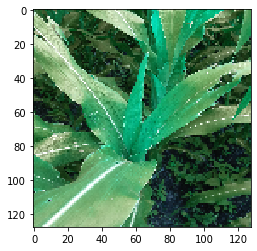

[[0.05833633 0.9416636 ]]


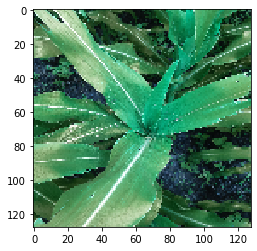

[[0.00301189 0.9969881 ]]


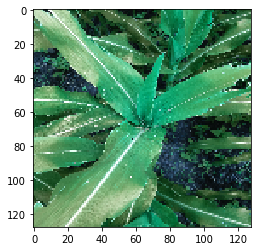

[[0.02205842 0.9779416 ]]


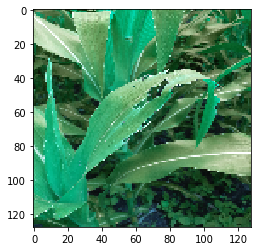

[[0.5473424  0.45265764]]


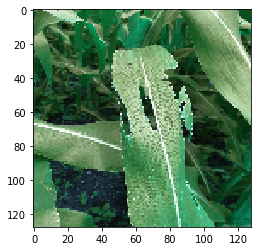

[[0.10934902 0.890651  ]]


In [30]:
for timg in idirs:
    timg = cv2.imread(timg)
    timg = cv2.resize(timg, (128, 128))
    plt.imshow(timg)
    plt.show()
    pred = model_loaded.predict(timg.reshape(-1, 128, 128, 3)/255)
    print(pred)